In [2]:
import pandas as pd
from copy import deepcopy
import os
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from tqdm import tqdm
from glob import glob

import pwlf

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Load and Filter Speed File

In [146]:
speed_file = '/scratch/ab9738/traffic/traffic-jams-uber/results/speeds_nairobi.csv'
speed_df = pd.read_csv(speed_file)

In [147]:
speed_df

,osm_wayid,s1,s2,max_speed,min_speed
0,677812730,13.923265,20.757885,45.092,3.880
1,259886381,33.285743,68.223624,95.375,1.587
2,583039625,10.621541,29.451291,60.469,3.643
3,187197450,17.944687,37.758301,66.580,12.060
4,674984258,19.562451,35.270415,67.559,1.225
...,...,...,...,...,...
3080,532650195,26.741411,38.448295,65.297,12.822
3081,95792925,10.632660,21.225265,46.629,0.748
3082,239795145,13.248042,22.192110,75.087,9.528
3083,563011788,21.410131,29.021804,55.127,0.738


In [129]:
# for sao_paulo only
def try_float(x):
    try:
        float(x)
        return True
    except:
        return False

speed_df = speed_df.loc[speed_df.min_speed.apply(try_float)]
speed_df = speed_df.loc[speed_df.max_speed.apply(try_float)]
speed_df = speed_df.loc[speed_df.s1.apply(try_float)]
speed_df = speed_df.loc[speed_df.s2.apply(try_float)]

speed_df['s1'] = speed_df['s1'].astype(float)
speed_df['s2'] = speed_df['s2'].astype(float)
speed_df['min_speed'] = speed_df['min_speed'].astype(float)
speed_df['max_speed'] = speed_df['max_speed'].astype(float)

speed_df

,osm_wayid,s1,s2,max_speed,min_speed
0,188462840,41.231892,52.068787,78.239,5.250
1,152906315,18.761777,37.430387,9.998,1.507
2,530679492,34.256919,39.506363,55.169,8.375
3,152980592,13.734787,27.509556,48.585,7.619
4,159518583,18.355847,27.500316,45.164,6.436
...,...,...,...,...,...
61228,95796003,1.437488,14.031042,33.670,1.125
61229,30636734,26.154080,37.270171,307.000,4.113
61230,221909500,16.842339,27.198826,60.299,6.760
61231,252061515,14.899487,41.365811,9.998,0.841


In [148]:
speed_df = speed_df[speed_df['min_speed']<speed_df['s1']]
speed_df = speed_df[speed_df['s1']<speed_df['s2']]
speed_df = speed_df[speed_df['s2']<speed_df['max_speed']]
speed_df = speed_df.reset_index(drop=True)

In [149]:
speed_df

,osm_wayid,s1,s2,max_speed,min_speed
0,677812730,13.923265,20.757885,45.092,3.880
1,259886381,33.285743,68.223624,95.375,1.587
2,583039625,10.621541,29.451291,60.469,3.643
3,187197450,17.944687,37.758301,66.580,12.060
4,674984258,19.562451,35.270415,67.559,1.225
...,...,...,...,...,...
3058,532650195,26.741411,38.448295,65.297,12.822
3059,95792925,10.632660,21.225265,46.629,0.748
3060,239795145,13.248042,22.192110,75.087,9.528
3061,563011788,21.410131,29.021804,55.127,0.738


## Load, Process and Filter Jam File

In [150]:
jam_file = '/scratch/ab9738/traffic/traffic-jams-uber/results/jams_nairobi.csv'
jam_df = pd.read_csv(jam_file)

In [151]:
jam_df

,osm_way_id,utc_timestamp,speed_kph_mean,Jam_Duration
0,677812730,2018-01-31 18:00:00,13.039,0 days 00:00:00
1,677812730,2019-04-05 16:00:00,13.064,0 days 00:00:00
2,677812730,2019-05-08 17:00:00,13.131,0 days 00:00:00
3,677812730,2019-05-16 16:00:00,11.932,0 days 00:00:00
4,677812730,2019-06-28 18:00:00,11.762,0 days 00:00:00
...,...,...,...,...
4103225,563011788,2020-01-08 14:00:00,11.884,0 days 02:00:00
4103226,563011788,2020-01-09 14:00:00,10.890,0 days 01:00:00
4103227,563011788,2020-01-13 14:00:00,9.175,0 days 02:00:00
4103228,563011788,2020-01-24 11:00:00,10.797,0 days 01:00:00


In [152]:
timestamp = jam_df['utc_timestamp']
timestamp = pd.to_datetime(timestamp, format="%Y-%m-%dT%H:%M:%S", errors='coerce')
jam_df['utc_timestamp'] = timestamp

duration = jam_df['Jam_Duration']
duration = pd.to_timedelta(duration, errors='coerce')
jam_df['Jam_Duration'] = duration

In [153]:
# jam_df = jam_df[jam_df['Jam_Duration']!=pd.Timedelta(hours=0)]
# jam_df = jam_df.reset_index(drop=True)
# jam_df

In [116]:
# For NYC Only
jam_df['speed_mph_mean'] = jam_df['speed_mph_mean']*1.6
jam_df.rename(columns={'speed_mph_mean':'speed_kph_mean'}, inplace=True)

In [154]:
valid_wayids = speed_df['osm_wayid'].to_numpy()
jam_df = jam_df.set_index('osm_way_id')
idx = jam_df.index.to_numpy()
loc_ids = np.intersect1d(valid_wayids, idx)
jam_df = jam_df.loc[loc_ids]

In [155]:
jam_df

,utc_timestamp,speed_kph_mean,Jam_Duration
osm_way_id,,,
4685092,2018-01-15 13:00:00,24.478,0 days
4685092,2018-01-16 13:00:00,32.975,0 days
4685092,2018-01-16 13:00:00,13.218,0 days
4685092,2018-01-26 15:00:00,13.047,0 days
4685092,2018-01-26 15:00:00,13.658,0 days
...,...,...,...
698498913,2020-03-25 14:00:00,20.587,0 days
698498913,2020-03-26 14:00:00,14.099,0 days
698498913,2020-03-27 13:00:00,18.860,0 days


In [158]:
jam_df_ = deepcopy(jam_df)

In [288]:
jam_df = jam_df_.loc[555497908]
jam_df

,utc_timestamp,speed_kph_mean,Jam_Duration
osm_way_id,,,
555497908,2018-01-15 13:00:00,12.179,2 days 17:00:00
555497908,2018-01-25 14:00:00,13.176,0 days 23:00:00
555497908,2018-02-01 13:00:00,13.424,2 days 03:00:00
555497908,2018-02-20 13:00:00,13.394,3 days 00:00:00
555497908,2018-05-02 12:00:00,12.176,0 days 03:00:00
555497908,2018-06-14 14:00:00,12.981,5 days 20:00:00
555497908,2019-03-27 13:00:00,7.511,0 days 01:00:00
555497908,2019-05-13 13:00:00,8.153,0 days 01:00:00
555497908,2019-06-27 13:00:00,11.110,0 days 01:00:00


## Plot Jam Times

In [279]:
jam_times = jam_df['utc_timestamp'].dt.strftime('%H').to_numpy().astype(int)

Text(0, 0.5, 'Relative Frequency')

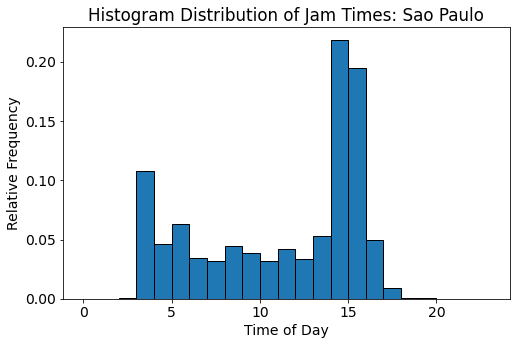

In [280]:
plt.figure(figsize=(8,5))
plt.hist(jam_times, bins=range(24), weights=np.ones_like(jam_times)/len(jam_times), edgecolor='black')
plt.title('Histogram Distribution of Jam Times: Sao Paulo')
plt.xlabel('Time of Day')
plt.ylabel('Relative Frequency')

## Plot Jam Durations

In [281]:
jam_durations = jam_df['Jam_Duration'].dt.components['days'].to_numpy()*24 + jam_df['Jam_Duration'].dt.components['hours'].to_numpy()

In [282]:
jam_durations = jam_durations+1

In [283]:
# jam_durations = jam_durations[jam_durations<10]

Text(0, 0.5, 'Relative Frequency')

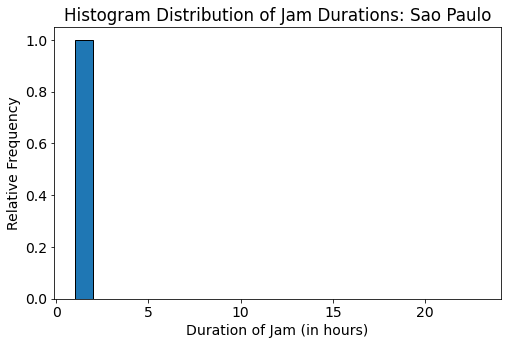

In [284]:
plt.figure(figsize=(8,5))
plt.hist(jam_durations,bins=range(1,24), weights=np.ones_like(jam_times)/len(jam_times), edgecolor='black')
plt.title('Histogram Distribution of Jam Durations: Sao Paulo')
plt.xlabel('Duration of Jam (in hours)')
plt.ylabel('Relative Frequency')

Average Number of hours per segment per day

In [285]:
np.sum(jam_durations)/((365+366+90.0)*len(speed_df))

0.001906372988197905

In [286]:
np.sum(jam_durations)

4794

In [287]:
np.sum(jam_durations)/(365+366+90.0)

5.839220462850183

## Plot Speed Distributions

In [48]:
s1 = speed_df['s1'].to_numpy()
s2 = speed_df['s2'].to_numpy()
mins = speed_df['min_speed'].to_numpy()
maxs = speed_df['max_speed'].to_numpy()
maxs = maxs[maxs<130]

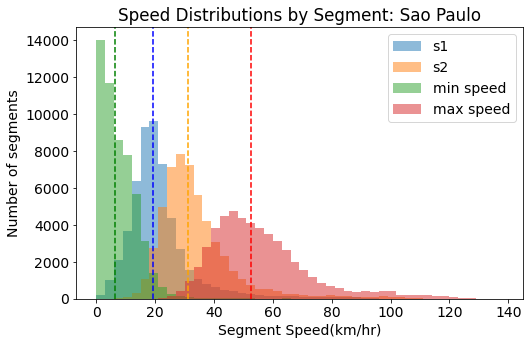

In [49]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,5))
plt.hist(s1, alpha=0.5, bins=range(0,140,3), label='s1')
plt.hist(s2, alpha=0.5, bins=range(0,140,3), label='s2')
plt.hist(mins, alpha=0.5, bins=range(0,140,3), label='min speed')
plt.hist(maxs, alpha=0.5, bins=range(0,140,3), label='max speed')
plt.axvline(np.median(mins), linestyle='dashed', color='green')
plt.axvline(np.median(maxs), linestyle='dashed', color='red')
plt.axvline(np.median(s1), linestyle='dashed', color='blue')
plt.axvline(np.median(s2), linestyle='dashed', color='orange')
plt.title('Speed Distributions by Segment: Sao Paulo')
plt.ylabel('Number of segments')
plt.xlabel('Segment Speed(km/hr)')
plt.legend()

## Plot number of jams with s1

In [148]:
speed_df = speed_df.set_index('osm_wayid')
speed_df = speed_df.loc[loc_ids]

In [149]:
speed_df

,s1,s2,max_speed,min_speed
osm_wayid,,,,
5029221,14.996111,42.136930,50.9632,3.5104
5668966,18.275689,41.610282,58.1680,2.8576
5668968,8.322603,23.078705,33.5200,4.7280
5668973,22.067607,43.388470,58.5200,8.4448
5668977,9.672885,25.499329,44.9632,3.3008
...,...,...,...,...
700238629,16.760826,23.898022,27.6448,7.8672
700407906,22.614384,35.570880,54.4464,2.1008
700407907,20.329679,34.119044,57.4288,1.1424


In [150]:
jam_freq = jam_df.groupby('osm_way_id').size().to_numpy()

In [151]:
s1 = speed_df['s1'].to_numpy()

In [152]:
sum(jam_df.index.unique() == speed_df.index)

22472

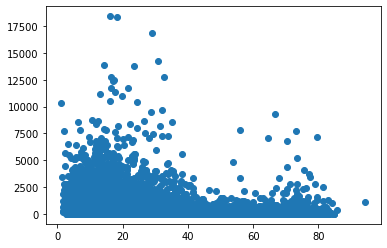

In [153]:
plt.scatter(s1, jam_freq)

## Plot jam duration with s1

In [154]:
jam_duration = jam_df.groupby('osm_way_id').Jam_Duration.sum()
jam_duration = jam_duration.dt.components['days']*24 + jam_duration.dt.components['hours']

In [155]:
jam_duration = jam_duration.to_numpy()

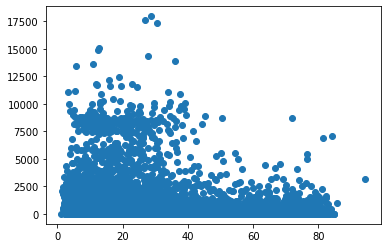

In [156]:
plt.scatter(s1, jam_duration)

In [22]:
df = pd.read_csv('/scratch/ab9738/traffic/data/nairobi-hexclusters-2020-1-All-DatesByHourBucketsAggregate.csv')

In [23]:
df = df.set_index(['sourceid', 'dstid'])

In [24]:
srcids = df.index.get_level_values('sourceid').unique().to_numpy()

In [17]:
np.random.seed(17)
np.random.shuffle(srcids)

In [26]:
def func(df):
    return(df.max()/df.mean())

tt_blow = []
for src in tqdm(srcids):
    dstids = df.loc[src].index.unique().to_numpy()
    tt_ = Parallel(n_jobs=12)(delayed(func)(df.loc[src,dst]['mean_travel_time']) for dst in dstids)
    tt_blow = tt_blow+tt_
    # for dst in dstids:
    #     df_ = df.loc[src,dst]['mean_travel_time']
    #     tt_blow.append(df_.max()/df_.mean())
        # tt = df_['mean_travel_time'].to_numpy()
        # print(np.mean(tt), np.max(tt), np.max(tt)/np.mean(tt))
        # tt_blow.append(np.max(tt)/np.mean(tt))
tt_blow = np.array(tt_blow)

100%|██████████| 371/371 [09:28<00:00,  1.53s/it]


Text(0, 0.5, 'Relative Frequency')

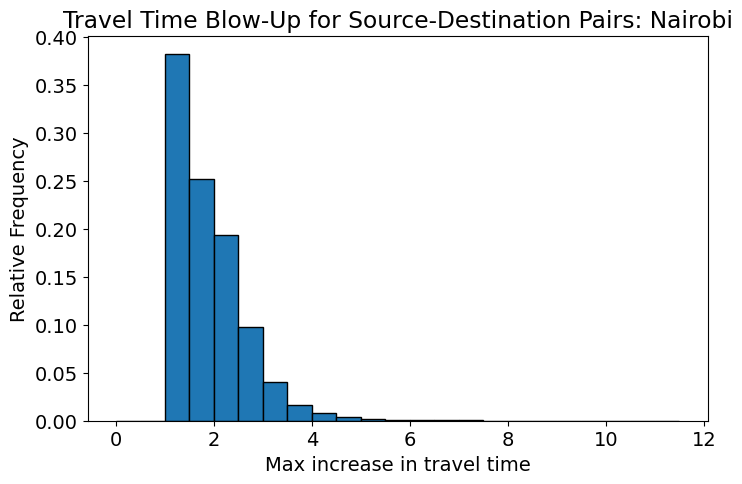

In [28]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,5))
plt.hist(tt_blow, bins=np.arange(24)*0.5, edgecolor='black', weights=np.ones_like(tt_blow)/len(tt_blow))
plt.title('Travel Time Blow-Up for Source-Destination Pairs: Nairobi')
plt.xlabel('Max increase in travel time')
plt.ylabel('Relative Frequency')